In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import qgrid
import gensim
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import nltk
os.chdir(os.getcwd() + '/..')
from data_io import *
from speech import *
import time
import matplotlib.pyplot as plt

/Users/pmatias/Library/Python/3.8/lib/python/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


Loading w2v window=5 dimension=100...done
Loading w2v window=5 dimension=150...done
Loading w2v window=5 dimension=200...done
Loading w2v window=10 dimension=100...done
Loading w2v window=10 dimension=150...done
Loading w2v window=10 dimension=200...done
Loading w2v window=15 dimension=100...done
Loading w2v window=15 dimension=150...done
Loading w2v window=15 dimension=200...done
Loading w2v window=20 dimension=100...done
Loading w2v window=20 dimension=150...done
Loading w2v window=20 dimension=200...done


In [226]:
# Read data.
labeled = load_data()
unlabeled = load_unlabeled_data()
all_data = labeled.data + unlabeled.data

-- train data
4370
-- dev data
414
Reading unlabeled data


In [72]:
is_dem = pd.DataFrame([
    ('OBAMA_PRIMARY2008', 1),
    ('PAUL_PRIMARY2012', 0),
    ('MCCAIN_PRIMARY2008', 0),
    ('CLINTON_PRIMARY2008', 1),
    ('ROMNEY_PRIMARY2008', 0),
    ('BACHMANN_PRIMARY2012', 0),
    ('GINGRICH_PRIMARY2012', 0),
    ('RICHARDSON_PRIMARY2008', 1),
    ('EDWARDS_PRIMARY2008', 1),
    ('GIULIANI_PRIMARY2008', 0),
    ('THOMPSON_PRIMARY2008', 0),
    ('HUCKABEE_PRIMARY2008', 0),
    ('ROMNEY_PRIMARY2012', 0),
    ('SANTORUM_PRIMARY2012', 0),
    ('PERRY_PRIMARY2012', 0),
    ('PAWLENTY_PRIMARY2012', 0),
    ('HUNTSMAN_PRIMARY2012', 0),
    ('BIDEN_PRIMARY2008', 0),
    ('CAIN_PRIMARY2012', 0)
]).set_index(0)
is_dem

,1
0,
OBAMA_PRIMARY2008,1
PAUL_PRIMARY2012,0
MCCAIN_PRIMARY2008,0
CLINTON_PRIMARY2008,1
ROMNEY_PRIMARY2008,0
BACHMANN_PRIMARY2012,0
GINGRICH_PRIMARY2012,0
RICHARDSON_PRIMARY2008,1
EDWARDS_PRIMARY2008,1


In [8]:
embedding_vectorizer = lambda : W2VAggVectorizerAvgTfidf(tfidf=TfidfVectorizer(tokenizer=nltk.word_tokenize, max_df=0.8), window=20, dim=200)
labeled_embeddings = embedding_vectorizer().fit_transform(np.array(labeled.data))

/Users/pmatias/Library/Python/3.8/lib/python/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


## GMM random seed

In [9]:
t0 = time.time()
pipe19_random = Pipeline([
  (f'avgw2v_tfidf', embedding_vectorizer()),
  ('gmm', GaussianMixture(n_components=19,
                    init_params='random',
                    verbose=10))
])
print("Computing clusters...", end='')
pipe19_random.fit(np.array(all_data))
print("done")
print("%0.2fs" % (time.time() - t0))

Computing clusters...

/Users/pmatias/Library/Python/3.8/lib/python/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Initialization 0
  Iteration 10	 time lapse 38.45003s	 ll change 0.36875
  Iteration 20	 time lapse 37.10747s	 ll change 0.10532
  Iteration 30	 time lapse 38.38709s	 ll change 0.04817
  Iteration 40	 time lapse 40.39167s	 ll change 0.02473
  Iteration 50	 time lapse 38.18357s	 ll change 0.01574
  Iteration 60	 time lapse 38.90654s	 ll change 0.00705
  Iteration 70	 time lapse 40.21865s	 ll change 0.00688
  Iteration 80	 time lapse 42.22165s	 ll change 0.00203
  Iteration 90	 time lapse 142.38786s	 ll change 0.00146
Initialization converged: True	 time lapse 471.87508s	 ll 579.72821
done
557.46s


In [26]:
gmm19_rnd = pipe19_random['gmm']
X_labeled19_rnd = pipe19_random['avgw2v_tfidf'].transform(np.array(labeled.data))
probs19_rnd = gmm19_rnd.predict_proba(X_labeled19_rnd)
probs19_rnd

array([[4.57200369e-094, 1.22007121e-030, 3.63870411e-052, ...,
        1.00413251e-215, 1.00000000e+000, 1.64961426e-185],
       [1.11072081e-236, 7.77643126e-037, 3.98624757e-052, ...,
        1.28640375e-107, 5.70394299e-102, 2.04473020e-023],
       [1.00000000e+000, 6.73106028e-068, 1.05397834e-026, ...,
        1.17454201e-022, 5.43001320e-024, 1.45582026e-038],
       ...,
       [3.67409854e-057, 1.25226814e-031, 7.33149030e-011, ...,
        7.36682295e-046, 3.41807014e-036, 3.44320133e-023],
       [1.18518750e-050, 1.00103004e-030, 1.93918796e-024, ...,
        9.99999951e-001, 1.04714297e-029, 1.89976192e-037],
       [1.00359738e-013, 4.87419697e-043, 6.07706329e-025, ...,
        9.98762872e-001, 3.73730376e-022, 1.05302991e-027]])

In [244]:
df = pd.DataFrame(probs19_rnd)
df['y'] = labeled.labels
candidates_probs_rnd = df.groupby('y').sum()

# Sort by dems
candidates_probs_rnd['is_dem'] = is_dem
candidates_probs_rnd.sort_values(by='is_dem', ascending=False, inplace=True)
candidates_probs_rnd.pop('is_dem')
candidates_probs_rnd

Loading w2v window=5 dimension=100...done
Loading w2v window=5 dimension=150...done
Loading w2v window=5 dimension=200...done
Loading w2v window=10 dimension=100...done
Loading w2v window=10 dimension=150...done
Loading w2v window=10 dimension=200...done
Loading w2v window=15 dimension=100...done
Loading w2v window=15 dimension=150...done
Loading w2v window=15 dimension=200...done
Loading w2v window=20 dimension=100...done
Loading w2v window=20 dimension=150...done
Loading w2v window=20 dimension=200...done


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
y,,,,,,,,,,,,,,,,,,,
CLINTON_PRIMARY2008,6.685070e+01,3.198438e+01,5.900183e+01,104.881839,8.002786e+01,1.496072e+02,1.466805e+02,59.011063,7.294791e+01,4.802386e+01,109.840602,2.700172e+01,8.719140e+01,6.189644e+01,3.906318e+01,136.184988,8.280638e+01,1.999578e+01,58.002463
EDWARDS_PRIMARY2008,2.800103e+01,7.000295e+00,1.399959e+01,32.035221,1.500487e+01,1.503366e+01,4.405573e+01,12.000875,2.200243e+01,9.001639e+00,39.859225,1.799441e+01,1.599434e+01,1.499950e+01,8.000137e+00,13.026237,1.699203e+01,3.005383e+00,11.993392
RICHARDSON_PRIMARY2008,7.288230e+01,3.999818e+00,1.805473e+01,21.524070,8.001022e+00,1.504370e+01,7.083592e+00,11.615483,6.002533e+00,8.002581e+00,29.070839,7.999942e+00,1.699942e+01,2.476491e+01,1.698093e+01,16.993628,2.398632e+01,1.298403e+01,14.010140
OBAMA_PRIMARY2008,7.042291e+01,2.700524e+01,2.498801e+01,35.774007,7.098975e+01,7.402324e+01,4.799649e+01,17.965498,7.218237e+01,2.681326e+01,52.274314,1.799989e+01,2.102492e+01,3.807172e+01,1.300581e+01,84.999444,9.237843e+01,2.000105e+01,38.083672
BACHMANN_PRIMARY2012,3.999999e+00,1.000000e+00,1.000000e+00,3.958827,1.000000e+00,3.000000e+00,3.000134e+00,1.029015,1.000000e+00,2.011963e+00,5.994005,1.000000e+00,5.999912e+00,1.000002e+00,2.000000e+00,0.006213,5.999975e+00,2.000057e+00,2.999899
PAUL_PRIMARY2012,9.999952e-01,2.998865e+00,1.215520e-07,7.000757,2.477868e-07,4.023332e+00,7.049341e+00,2.000000,1.009232e+00,2.000116e+00,7.962080,1.000000e+00,9.999967e-01,3.000000e+00,8.000000e+00,5.000266,1.956003e+00,5.716356e-09,5.000016
SANTORUM_PRIMARY2012,1.306095e-09,7.999121e+00,2.999853e+00,5.984476,1.999691e+00,9.988088e+00,1.601680e+01,6.000083,7.007309e+00,5.000413e+00,8.996685,2.000000e+00,6.999559e+00,1.001188e+01,9.999991e+00,26.021694,9.982920e+00,5.999985e+00,5.991448
ROMNEY_PRIMARY2012,9.031911e+00,9.023161e+00,4.000077e+00,6.996036,2.000004e+00,1.699271e+01,5.899864e+00,4.000424,1.999624e+01,1.000346e+00,10.987929,9.925764e-01,1.001905e+01,5.961546e+00,5.000000e+00,15.086224,3.301229e+01,7.999645e+00,4.999970
ROMNEY_PRIMARY2008,4.029726e+00,4.009115e+00,2.474196e-08,0.974873,2.000000e+00,4.020441e+00,2.000024e+00,1.000000,9.961268e+00,1.000000e+00,3.970172,5.360331e-18,2.000357e+00,1.000106e+00,1.000006e+00,2.001568,2.000300e+01,8.029369e+00,1.999970


In [245]:
candidates_probs_rnd_norm = normalize(candidates_probs_rnd, norm='l1', axis=0)
mapping = pd.DataFrame([np.random.choice(candidates_probs_rnd.index, p=col) for col in candidates_probs_rnd_norm.T])
mapping
# candidates_probs_rnd.values

,0
0,ROMNEY_PRIMARY2012
1,CLINTON_PRIMARY2008
2,CLINTON_PRIMARY2008
3,BIDEN_PRIMARY2008
4,EDWARDS_PRIMARY2008
5,SANTORUM_PRIMARY2012
6,GIULIANI_PRIMARY2008
7,CLINTON_PRIMARY2008
8,CLINTON_PRIMARY2008
9,GINGRICH_PRIMARY2012


In [235]:
centroid_predictions = pipe19_random.predict(unlabeled.data[:10])
centroid_predictions

array([ 0,  4, 18,  5,  9,  4, 10,  5, 16, 12])

In [236]:
unlabeled_labels = pd.Series(a0).map(mapping.squeeze())
unlabeled_labels

0    RICHARDSON_PRIMARY2008
1       EDWARDS_PRIMARY2008
2      GINGRICH_PRIMARY2012
3         OBAMA_PRIMARY2008
4       CLINTON_PRIMARY2008
5       EDWARDS_PRIMARY2008
6       CLINTON_PRIMARY2008
7         OBAMA_PRIMARY2008
8         OBAMA_PRIMARY2008
9      HUCKABEE_PRIMARY2008
dtype: object

In [240]:
pd.DataFrame(dict(
    fname=list(map(lambda fname: f'unlabeled/{fname}', unlabeled.fnames[:10])),
    label=unlabeled_labels
))

,fname,label
0,unlabeled/00000.txt,RICHARDSON_PRIMARY2008
1,unlabeled/00004.txt,EDWARDS_PRIMARY2008
2,unlabeled/00005.txt,GINGRICH_PRIMARY2012
3,unlabeled/00006.txt,OBAMA_PRIMARY2008
4,unlabeled/00010.txt,CLINTON_PRIMARY2008
5,unlabeled/00012.txt,EDWARDS_PRIMARY2008
6,unlabeled/00014.txt,CLINTON_PRIMARY2008
7,unlabeled/00016.txt,OBAMA_PRIMARY2008
8,unlabeled/00021.txt,OBAMA_PRIMARY2008
9,unlabeled/00025.txt,HUCKABEE_PRIMARY2008


In [234]:
list(map(lambda fname: f'unlabeled/{fname}', unlabeled.fnames))

['unlabeled/00000.txt',
 'unlabeled/00004.txt',
 'unlabeled/00005.txt',
 'unlabeled/00006.txt',
 'unlabeled/00010.txt',
 'unlabeled/00012.txt',
 'unlabeled/00014.txt',
 'unlabeled/00016.txt',
 'unlabeled/00021.txt',
 'unlabeled/00025.txt',
 'unlabeled/00027.txt',
 'unlabeled/00030.txt',
 'unlabeled/00031.txt',
 'unlabeled/00034.txt',
 'unlabeled/00035.txt',
 'unlabeled/00036.txt',
 'unlabeled/00037.txt',
 'unlabeled/00038.txt',
 'unlabeled/00040.txt',
 'unlabeled/00047.txt',
 'unlabeled/00050.txt',
 'unlabeled/00052.txt',
 'unlabeled/00053.txt',
 'unlabeled/00054.txt',
 'unlabeled/00056.txt',
 'unlabeled/00057.txt',
 'unlabeled/00059.txt',
 'unlabeled/00060.txt',
 'unlabeled/00062.txt',
 'unlabeled/00064.txt',
 'unlabeled/00072.txt',
 'unlabeled/00074.txt',
 'unlabeled/00076.txt',
 'unlabeled/00083.txt',
 'unlabeled/00084.txt',
 'unlabeled/00088.txt',
 'unlabeled/00089.txt',
 'unlabeled/00091.txt',
 'unlabeled/00093.txt',
 'unlabeled/00097.txt',
 'unlabeled/00098.txt',
 'unlabeled/0010

In [179]:
candidates_probs_rnd.sum(axis=1)

y
CLINTON_PRIMARY2008       1441.0
EDWARDS_PRIMARY2008        340.0
RICHARDSON_PRIMARY2008     336.0
OBAMA_PRIMARY2008          846.0
BACHMANN_PRIMARY2012        48.0
PAUL_PRIMARY2012            60.0
SANTORUM_PRIMARY2012       149.0
ROMNEY_PRIMARY2012         173.0
ROMNEY_PRIMARY2008          69.0
PERRY_PRIMARY2012           68.0
PAWLENTY_PRIMARY2012        40.0
MCCAIN_PRIMARY2008         408.0
BIDEN_PRIMARY2008           58.0
HUNTSMAN_PRIMARY2012        28.0
HUCKABEE_PRIMARY2008       130.0
GIULIANI_PRIMARY2008       247.0
GINGRICH_PRIMARY2012       181.0
CAIN_PRIMARY2012            17.0
THOMPSON_PRIMARY2008       145.0
dtype: float64

In [27]:
unlabeled.y = pipe19_random.predict(unlabeled.data)

In [28]:
unlabeled.y

array([ 0,  4, 18, ..., 16,  6,  6])

In [14]:
t0 = time.time()
pipe19_kmeans = Pipeline([
  (f'avgw2v_tfidf', embedding_vectorizer()),
  ('kmeans', KMeans(n_clusters=19,
                    init='k-means++',
                    verbose=10,
                    n_jobs=-1))
])
print("Computing clusters...", end='')
pipe19_kmeans.fit(np.array(all_data))
print("done")
print("%0.2fs" % (time.time() - t0))

Computing clusters...

/Users/pmatias/Library/Python/3.8/lib/python/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/Users/pmatias/Library/Python/3.8/lib/python/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Initialization complete
Iteration 0, inertia 372341.8566770646
Iteration 1, inertia 266148.4144120114
Iteration 2, inertia 258718.01851714784
Iteration 3, inertia 256611.7686203651
Iteration 4, inertia 255468.45747736425
Iteration 5, inertia 254429.5799800913
Iteration 6, inertia 253503.61991264563
Iteration 7, inertia 252903.84252024474
Iteration 8, inertia 252665.81973611648
Iteration 9, inertia 252531.8425342256
Iteration 10, inertia 252436.9661869622
Iteration 11, inertia 252360.5457276508
Iteration 12, inertia 252293.5389855566
Iteration 13, inertia 252239.24151174928
Iteration 14, inertia 252188.66794837822
Iteration 15, inertia 252141.0291995209
Iteration 16, inertia 252093.93563569227
Iteration 17, inertia 252034.31370386825
Iteration 18, inertia 251978.46809607744
Iteration 19, inertia 251926.6007184927
Iteration 20, inertia 251879.56786331197
Iteration 21, inertia 251835.1948323618
Iteration 22, inertia 251788.34193562085
Iteration 23, inertia 251746.53052491942
Iteration 24,

Iteration 199, inertia 250717.3224826076
Iteration 200, inertia 250716.95487283528
Iteration 201, inertia 250716.53249672876
Iteration 202, inertia 250716.0903108137
Iteration 203, inertia 250715.60773980123
Iteration 204, inertia 250715.15206606715
Iteration 205, inertia 250714.81264684428
Iteration 206, inertia 250714.56104670736
Iteration 207, inertia 250714.26245494236
Iteration 208, inertia 250713.77221909937
Iteration 209, inertia 250713.28816865658
Iteration 210, inertia 250712.67541830224
Iteration 211, inertia 250712.0882438443
Iteration 212, inertia 250711.48096112144
Iteration 213, inertia 250710.64401996025
Iteration 214, inertia 250709.83996659744
Iteration 215, inertia 250708.91976785832
Iteration 216, inertia 250707.74050898053
Iteration 217, inertia 250706.559453059
Iteration 218, inertia 250705.6223737385
Iteration 219, inertia 250704.7788330603
Iteration 220, inertia 250703.61267787695
Iteration 221, inertia 250702.49383188222
Iteration 222, inertia 250701.11112439292

Iteration 20, inertia 249119.40981370417
Iteration 21, inertia 249102.52300229194
Iteration 22, inertia 249089.5297482074
Iteration 23, inertia 249079.8619696312
Iteration 24, inertia 249072.26830987248
Iteration 25, inertia 249065.78025110715
Iteration 26, inertia 249060.39260977317
Iteration 27, inertia 249055.51990943943
Iteration 28, inertia 249050.63523434984
Iteration 29, inertia 249046.34781600448
Iteration 30, inertia 249042.89187982088
Iteration 31, inertia 249040.2967415403
Iteration 32, inertia 249038.4647915696
Iteration 33, inertia 249036.97119235015
Iteration 34, inertia 249035.47510575157
Iteration 35, inertia 249033.90008503693
Iteration 36, inertia 249032.42069272033
Iteration 37, inertia 249031.09623641236
Iteration 38, inertia 249030.08760963703
Iteration 39, inertia 249029.14554463836
Iteration 40, inertia 249028.40048629078
Iteration 41, inertia 249027.8536231745
Iteration 42, inertia 249027.35021421334
Iteration 43, inertia 249026.8512345228
Iteration 44, inertia 

Iteration 129, inertia 251069.08800526694
Iteration 130, inertia 251068.85029957758
Iteration 131, inertia 251068.61981661152
Iteration 132, inertia 251068.34732069113
Iteration 133, inertia 251068.02653992848
Iteration 134, inertia 251067.65496094862
Iteration 135, inertia 251067.00718018392
Iteration 136, inertia 251066.29198225352
Iteration 137, inertia 251065.64420735973
Iteration 138, inertia 251065.25404858778
Iteration 139, inertia 251064.86734084084
Iteration 140, inertia 251064.53227917815
Iteration 141, inertia 251064.32224741767
Iteration 142, inertia 251064.10469215093
Iteration 143, inertia 251063.8880151472
Iteration 144, inertia 251063.58242132893
Iteration 145, inertia 251063.35623623282
Iteration 146, inertia 251063.085301692
Iteration 147, inertia 251062.72456313414
Iteration 148, inertia 251062.32210859543
Iteration 149, inertia 251061.8328901332
Iteration 150, inertia 251061.15327187825
Iteration 151, inertia 251060.44574134765
Iteration 152, inertia 251059.61352363

Iteration 48, inertia 251011.00550222764
Iteration 49, inertia 251006.8670573847
Iteration 50, inertia 251003.73334261507
Iteration 51, inertia 251001.2654729978
Iteration 52, inertia 250999.01002070968
Iteration 53, inertia 250996.37165716183
Iteration 54, inertia 250992.9708610587
Iteration 55, inertia 250989.6553456626
Iteration 56, inertia 250987.17781709065
Iteration 57, inertia 250985.47886969874
Iteration 58, inertia 250984.07898175184
Iteration 59, inertia 250982.63876096465
Iteration 60, inertia 250981.4796889967
Iteration 61, inertia 250980.35710424234
Iteration 62, inertia 250978.92647878284
Iteration 63, inertia 250977.36860202762
Iteration 64, inertia 250975.9552027359
Iteration 65, inertia 250974.54998690993
Iteration 66, inertia 250973.19826634706
Iteration 67, inertia 250971.60063946474
Iteration 68, inertia 250969.39339902657
Iteration 69, inertia 250967.91748408662
Iteration 70, inertia 250966.85871030003
Iteration 71, inertia 250965.96500873994
Iteration 72, inertia 

Iteration 68, inertia 248789.38034063327
Iteration 69, inertia 248786.5099375268
Iteration 70, inertia 248785.0217487525
Iteration 71, inertia 248784.03912163188
Iteration 72, inertia 248783.21534149445
Iteration 73, inertia 248782.04033515952
Iteration 74, inertia 248780.71551990425
Iteration 75, inertia 248779.79896688234
Iteration 76, inertia 248779.0391922499
Iteration 77, inertia 248778.46038425053
Iteration 78, inertia 248777.77626609942
Iteration 79, inertia 248776.99345690664
Iteration 80, inertia 248776.3133778911
Iteration 81, inertia 248775.63459005704
Iteration 82, inertia 248774.90936359382
Iteration 83, inertia 248774.09154473507
Iteration 84, inertia 248773.25137798852
Iteration 85, inertia 248772.2059103569
Iteration 86, inertia 248770.98753732018
Iteration 87, inertia 248769.83418215183
Iteration 88, inertia 248768.99725278726
Iteration 89, inertia 248768.3853008372
Iteration 90, inertia 248767.86683701831
Iteration 91, inertia 248767.3976560608
Iteration 92, inertia 2

Iteration 87, inertia 251129.81691732517
Iteration 88, inertia 251129.6284655189
Iteration 89, inertia 251129.42918796284
Iteration 90, inertia 251129.21723010938
Iteration 91, inertia 251128.96182033388
Iteration 92, inertia 251128.66791476117
Iteration 93, inertia 251128.2346365086
Iteration 94, inertia 251127.7624937107
Iteration 95, inertia 251127.04376324092
Iteration 96, inertia 251126.02172878585
Iteration 97, inertia 251124.87018242435
Iteration 98, inertia 251123.39623766483
Iteration 99, inertia 251121.70947517775
Iteration 100, inertia 251119.85214045143
Iteration 101, inertia 251117.6268268226
Iteration 102, inertia 251114.79162153674
Iteration 103, inertia 251111.07958058
Iteration 104, inertia 251105.16508000356
Iteration 105, inertia 251100.06452119956
Iteration 106, inertia 251096.147700813
Iteration 107, inertia 251092.26795506693
Iteration 108, inertia 251088.63182133774
Iteration 109, inertia 251085.96332005647
Iteration 110, inertia 251083.63335157427
Iteration 111,

Iteration 9, inertia 250859.23290933212
Iteration 10, inertia 250630.64916115557
Iteration 11, inertia 250470.30369313873
Iteration 12, inertia 250331.64588043388
Iteration 13, inertia 250221.13462501098
Iteration 14, inertia 250116.41601090596
Iteration 15, inertia 250009.48395067395
Iteration 16, inertia 249908.97145452886
Iteration 17, inertia 249797.6353528584
Iteration 18, inertia 249682.5120540913
Iteration 19, inertia 249573.3782342441
Iteration 20, inertia 249477.63424245353
Iteration 21, inertia 249399.47872892505
Iteration 22, inertia 249343.5073503781
Iteration 23, inertia 249294.5880879243
Iteration 24, inertia 249248.56629327932
Iteration 25, inertia 249204.04706733048
Iteration 26, inertia 249164.65335130488
Iteration 27, inertia 249134.17600084023
Iteration 28, inertia 249107.07984336646
Iteration 29, inertia 249081.73144922673
Iteration 30, inertia 249061.3915503859
Iteration 31, inertia 249045.15163859693
Iteration 32, inertia 249031.4547543931
Iteration 33, inertia 24

Iteration 83, inertia 250938.10751562318
Iteration 84, inertia 250937.77495531112
Iteration 85, inertia 250937.51986160106
Iteration 86, inertia 250937.28983775456
Iteration 87, inertia 250937.07021496908
Iteration 88, inertia 250936.9387209173
Iteration 89, inertia 250936.82776787117
Iteration 90, inertia 250936.73226733328
Iteration 91, inertia 250936.5575694721
Iteration 92, inertia 250936.34816122465
Iteration 93, inertia 250936.0646229118
Iteration 94, inertia 250935.7432089817
Iteration 95, inertia 250935.3879763807
Iteration 96, inertia 250935.08206629322
Iteration 97, inertia 250934.8818285763
Iteration 98, inertia 250934.73144111142
Iteration 99, inertia 250934.56478563996
Iteration 100, inertia 250934.37858721786
Iteration 101, inertia 250934.2738673765
Iteration 102, inertia 250934.22515949613
Iteration 103, inertia 250934.2033040629
Iteration 104, inertia 250934.18827534298
Converged at iteration 104: center shift 2.1732637734193217e-06 within tolerance 4.178699342606584e-0

In [15]:
cluster_predictions_19_kmeans = pipe19_kmeans.transform(labeled.data)
cluster_predictions_19_kmeans = normalize(cluster_predictions_19_kmeans, norm='l1')

In [249]:
df = pd.DataFrame(cluster_predictions_19_kmeans)
df['y'] = labeled.labels
candidates_probs_kmeans = df.groupby('y').sum()
candidates_probs_kmeans

# Sort by dems
candidates_probs_kmeans['is_dem'] = is_dem
candidates_probs_kmeans.sort_values(by='is_dem', ascending=False, inplace=True)
candidates_probs_kmeans.pop('is_dem')
candidates_probs_kmeans

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
y,,,,,,,,,,,,,,,,,,,
CLINTON_PRIMARY2008,75.033280,68.423856,66.835180,73.179289,61.849183,82.641322,69.123924,84.586641,81.724474,77.324980,70.823685,74.920558,78.883100,72.948372,126.369708,70.313507,66.266157,72.158360,67.594425
EDWARDS_PRIMARY2008,17.831702,15.922481,16.130721,17.823164,14.629685,19.334314,15.799855,19.966230,19.459994,18.784262,16.654686,16.684932,17.496634,17.928113,30.120777,17.217908,16.062753,16.406751,15.745038
RICHARDSON_PRIMARY2008,20.066321,13.556790,15.928004,17.939626,14.989271,21.016226,14.954138,19.720332,19.905241,16.881311,14.430210,15.188007,14.637867,19.047035,31.305947,18.194682,15.253953,16.828344,16.156697
OBAMA_PRIMARY2008,46.355570,38.533240,38.093852,43.760709,36.796164,52.330726,37.414871,48.292723,50.335062,45.426464,40.731082,41.774074,43.061417,43.982951,77.016418,42.905996,38.514740,40.595903,40.078040
BACHMANN_PRIMARY2012,2.851762,1.997563,2.259857,2.655248,2.131640,2.956671,2.044636,2.659033,2.796776,2.550488,2.281085,2.331482,2.295652,2.546003,4.403185,2.472009,2.080753,2.435221,2.250936
PAUL_PRIMARY2012,2.899852,3.015088,2.906905,3.132576,2.461646,3.219610,2.922694,3.538171,3.102168,3.394079,3.129901,3.120811,3.375950,3.073574,5.041480,2.973109,2.918659,2.918242,2.855486
SANTORUM_PRIMARY2012,7.488357,7.524807,7.072537,7.880735,6.430239,8.128500,7.258213,8.671330,7.782904,8.431434,7.930358,8.151615,8.741207,7.116619,12.235851,6.827823,6.823597,7.552319,6.951554
ROMNEY_PRIMARY2012,10.061921,7.679946,8.237740,9.362314,7.858853,10.720093,7.771468,8.470467,10.139287,8.939794,8.240399,8.867200,8.690990,9.096939,15.211600,8.879238,7.745997,8.736330,8.289423
ROMNEY_PRIMARY2008,4.070167,3.027595,3.223258,3.900497,3.131002,4.296425,2.944272,3.159339,4.112796,3.810687,3.452362,3.519605,3.462635,3.571712,6.094983,3.442383,3.015467,3.482663,3.282153


In [250]:
candidates_probs_kmeans.sum(axis=1)

y
CLINTON_PRIMARY2008       1441.0
EDWARDS_PRIMARY2008        340.0
RICHARDSON_PRIMARY2008     336.0
OBAMA_PRIMARY2008          846.0
BACHMANN_PRIMARY2012        48.0
PAUL_PRIMARY2012            60.0
SANTORUM_PRIMARY2012       149.0
ROMNEY_PRIMARY2012         173.0
ROMNEY_PRIMARY2008          69.0
PERRY_PRIMARY2012           68.0
PAWLENTY_PRIMARY2012        40.0
MCCAIN_PRIMARY2008         408.0
BIDEN_PRIMARY2008           58.0
HUNTSMAN_PRIMARY2012        28.0
HUCKABEE_PRIMARY2008       130.0
GIULIANI_PRIMARY2008       247.0
GINGRICH_PRIMARY2012       181.0
CAIN_PRIMARY2012            17.0
THOMPSON_PRIMARY2008       145.0
dtype: float64

Text(0.5, 1.0, 'GMM')

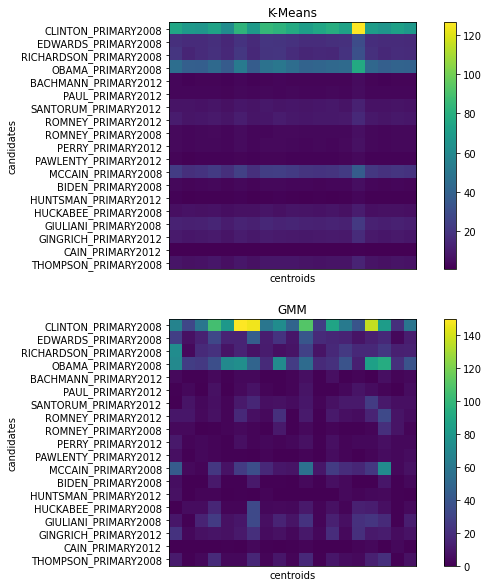

In [259]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))

im = axs[0].imshow(candidates_probs_kmeans)
fig.colorbar(im, ax=axs[0])
axs[0].set_xticks([])
axs[0].set_yticks(range(19))
axs[0].set_xlabel('centroids')
axs[0].set_ylabel('candidates')
axs[0].set_yticklabels(candidates_probs_rnd.index.values)
axs[0].set_title('K-Means')

im = axs[1].imshow(candidates_probs_rnd)
fig.colorbar(im, ax=axs[1])
axs[1].set_xticks([])
axs[1].set_yticks(range(19))
axs[1].set_xlabel('centroids')
axs[1].set_ylabel('candidates')
axs[1].set_yticklabels(candidates_probs_rnd.index.values)
axs[1].set_title('GMM')


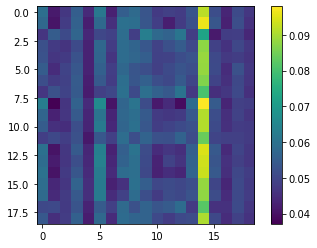

In [17]:
plt.imshow(candidates_probs_kmeans)
plt.colorbar()

# GMM kmeans seed

# GMM labeled seed

In [7]:
# Compute embeddings of labeled data to use as seed for means
embedding_vectorizer_glove = lambda : TfidfEmbeddingVectorizer(word2vec_glove, tokenizer=nltk.word_tokenize)
X_labeled_glove = embedding_vectorizer_glove().fit_transform(np.array(labeled.data))

/Users/pmatias/Library/Python/3.8/lib/python/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [8]:
df = pd.DataFrame(X_labeled_glove)
df['y'] = labeled.labels
labeled_centroids = df.groupby('y').mean()
labeled_centroids

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
y,,,,,,,,,,,,,,,,,,,,,
BACHMANN_PRIMARY2012,0.164610,0.098577,0.033895,-0.201509,0.322093,0.166664,-0.347341,-0.106655,-0.079611,-0.058131,...,-0.277816,0.011554,0.140589,0.115085,-0.090857,0.137257,-0.348573,0.096499,-0.082646,0.025118
BIDEN_PRIMARY2008,0.303578,-0.000110,0.049224,-0.172442,0.326249,0.061844,-0.237564,-0.021351,-0.074913,-0.101820,...,-0.260247,0.037856,0.086759,0.086359,-0.070475,0.096566,-0.217901,0.115324,-0.123980,0.013557
CAIN_PRIMARY2012,0.189686,0.192203,0.026769,-0.164510,0.402392,0.034748,-0.386104,0.004887,-0.252507,-0.016524,...,-0.173025,0.102484,-0.034259,0.165175,0.000278,0.158957,-0.242036,-0.088410,-0.071893,0.070637
CLINTON_PRIMARY2008,0.237577,0.098436,0.066522,-0.203030,0.318832,0.100316,-0.406012,-0.064363,-0.109119,-0.023743,...,-0.272941,0.037511,0.104885,0.187433,-0.024851,0.088690,-0.227949,0.043129,-0.081148,0.120701
EDWARDS_PRIMARY2008,0.238342,0.082394,0.074764,-0.176524,0.313114,0.084583,-0.354291,-0.063513,-0.121561,-0.043889,...,-0.277220,0.045570,0.124720,0.159046,-0.019521,0.098245,-0.254193,0.078502,-0.091761,0.090535
GINGRICH_PRIMARY2012,0.190209,0.086641,0.090124,-0.143124,0.291302,0.096339,-0.363983,-0.100068,-0.126401,0.024926,...,-0.249801,0.041342,0.060203,0.143201,-0.081807,0.105154,-0.211479,0.088994,-0.044065,0.133453
GIULIANI_PRIMARY2008,0.235013,0.083943,0.022509,-0.185494,0.361668,0.084272,-0.333799,-0.075616,-0.181447,-0.038167,...,-0.226051,0.057921,0.085597,0.150270,-0.059299,0.109101,-0.227623,0.052054,-0.075080,0.119571
HUCKABEE_PRIMARY2008,0.185754,0.103151,0.045542,-0.189569,0.407700,0.077010,-0.425234,-0.020022,-0.202821,-0.018842,...,-0.236793,0.101603,0.013562,0.202331,-0.056259,0.116070,-0.253902,0.010962,-0.071400,0.161928
HUNTSMAN_PRIMARY2012,0.216256,0.056876,0.013232,-0.111481,0.248539,0.092775,-0.278131,-0.084794,-0.021022,-0.026136,...,-0.287907,-0.079909,0.138040,0.133807,-0.076036,0.152875,-0.212005,0.092040,-0.083704,-0.093432


In [10]:
cosine_similarities = pd.DataFrame(cosine_similarity(labeled_centroids.values)).set_index(labeled_centroids.index)
cosine_similarities

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
y,,,,,,,,,,,,,,,,,,,
BACHMANN_PRIMARY2012,1.000000,0.992114,0.976709,0.992539,0.994761,0.992469,0.992913,0.985542,0.991860,0.995522,0.994363,0.986057,0.994823,0.995648,0.994343,0.993477,0.995056,0.988807,0.994200
BIDEN_PRIMARY2008,0.992114,1.000000,0.978704,0.991056,0.994863,0.991205,0.994147,0.985520,0.990226,0.995072,0.993562,0.987131,0.991236,0.991158,0.993778,0.988145,0.991265,0.986066,0.995202
CAIN_PRIMARY2012,0.976709,0.978704,1.000000,0.987092,0.986396,0.984642,0.991092,0.995668,0.965476,0.980769,0.986134,0.990816,0.970992,0.971017,0.968872,0.986600,0.981928,0.993042,0.989597
CLINTON_PRIMARY2008,0.992539,0.991056,0.987092,1.000000,0.998778,0.997681,0.997756,0.995140,0.988486,0.996347,0.999129,0.996072,0.989530,0.994137,0.992329,0.992617,0.997296,0.997377,0.997182
EDWARDS_PRIMARY2008,0.994761,0.994863,0.986396,0.998778,1.000000,0.997593,0.998417,0.994102,0.991466,0.998521,0.999147,0.995857,0.993316,0.995338,0.994957,0.993259,0.997450,0.995737,0.998709
GINGRICH_PRIMARY2012,0.992469,0.991205,0.984642,0.997681,0.997593,1.000000,0.997291,0.993582,0.988868,0.995100,0.997016,0.994978,0.990944,0.994119,0.991987,0.990285,0.997500,0.995605,0.996031
GIULIANI_PRIMARY2008,0.992913,0.994147,0.991092,0.997756,0.998417,0.997291,1.000000,0.996630,0.986988,0.996009,0.997576,0.996898,0.989416,0.991569,0.990548,0.994107,0.995761,0.996734,0.999174
HUCKABEE_PRIMARY2008,0.985542,0.985520,0.995668,0.995140,0.994102,0.993582,0.996630,1.000000,0.975896,0.989864,0.993540,0.996217,0.980668,0.982303,0.979825,0.990051,0.990301,0.998145,0.995202
HUNTSMAN_PRIMARY2012,0.991860,0.990226,0.965476,0.988486,0.991466,0.988868,0.986988,0.975896,1.000000,0.993746,0.992079,0.982031,0.994618,0.996004,0.995927,0.986595,0.993033,0.981692,0.989988


In [12]:
dotproduct_similarities = labeled_centroids.dot(labeled_centroids.T)
dotproduct_similarities

y,BACHMANN_PRIMARY2012,BIDEN_PRIMARY2008,CAIN_PRIMARY2012,CLINTON_PRIMARY2008,EDWARDS_PRIMARY2008,GINGRICH_PRIMARY2012,GIULIANI_PRIMARY2008,HUCKABEE_PRIMARY2008,HUNTSMAN_PRIMARY2012,MCCAIN_PRIMARY2008,OBAMA_PRIMARY2008,PAUL_PRIMARY2012,PAWLENTY_PRIMARY2012,PERRY_PRIMARY2012,RICHARDSON_PRIMARY2008,ROMNEY_PRIMARY2008,ROMNEY_PRIMARY2012,SANTORUM_PRIMARY2012,THOMPSON_PRIMARY2008
y,,,,,,,,,,,,,,,,,,,
BACHMANN_PRIMARY2012,11.794016,11.719420,12.177230,12.261582,12.244327,11.798194,12.289241,12.422126,11.364696,11.881573,12.093515,12.495533,11.874647,11.560055,11.839312,11.034851,11.312629,12.184256,12.261873
BIDEN_PRIMARY2008,11.719420,11.831150,12.221298,12.262524,12.264836,11.801706,12.323865,12.441387,11.363824,11.894884,12.102778,12.528819,11.850436,11.526029,11.851206,10.992898,11.287267,12.169597,12.293535
CAIN_PRIMARY2012,12.177230,12.221298,13.179693,12.890759,12.834795,12.373671,12.967308,13.266527,11.694205,12.374035,12.678416,13.272957,12.252148,11.917983,12.194902,11.584344,11.800965,12.935308,12.902187
CLINTON_PRIMARY2008,12.261582,12.262524,12.890759,12.940068,12.877226,12.423036,12.935282,13.138395,11.863577,12.455782,12.728185,13.221502,12.372030,12.090317,12.376093,11.548560,11.876199,12.873136,12.882349
EDWARDS_PRIMARY2008,12.244327,12.264836,12.834795,12.877226,12.846070,12.376746,12.896748,13.076938,11.856045,12.437540,12.682093,13.170550,12.374184,12.060879,12.363719,11.513977,11.834823,12.805193,12.855130
GINGRICH_PRIMARY2012,11.798194,11.801706,12.373671,12.423036,12.376746,11.982170,12.441492,12.622958,11.420443,11.970893,12.222121,12.708763,11.922318,11.634006,11.905106,11.086794,11.430525,12.365489,12.382051
GIULIANI_PRIMARY2008,12.289241,12.323865,12.967308,12.935282,12.896748,12.441492,12.988713,13.182781,11.867836,12.474938,12.732267,13.257318,12.393835,12.081733,12.377077,11.587619,11.880198,12.888984,12.932313
HUCKABEE_PRIMARY2008,12.422126,12.441387,13.266527,13.138395,13.076938,12.622958,13.182781,13.470379,11.950067,12.625753,12.913732,13.491676,12.509957,12.188729,12.468030,11.752369,12.032129,13.144380,13.117572
HUNTSMAN_PRIMARY2012,11.364696,11.363824,11.694205,11.863577,11.856045,11.420443,11.867836,11.950067,11.131495,11.522433,11.721945,12.089935,11.533917,11.234690,11.520297,10.646172,10.967955,11.751909,11.862023


In [ ]:
# Determine weights proportional to affiliation from labels
def weights_from_labeled():
    df = pd.DataFrame(labeled.labels)
    df['a'] = 1
    return df.groupby(0).sum() / len(labeled.labels)

In [48]:
pipe_19_glove_labelinit = Pipeline([
  (f'avgw2v_tfidf', embedding_vectorizer_glove()),
  ('gmm', GaussianMixture(n_components=19,
                    init_params='random',
                    weights_init=weights_from_labeled().values.ravel(),
                    means_init=labeled_centroids.values,
                    verbose=10))
])

print("Computing clusters...", end='')
pipe_19_glove_labelinit.fit(np.array(all_data))
print("done")
print("%0.2fs" % (time.time() - t0))

Computing clusters...

/Users/pmatias/Library/Python/3.8/lib/python/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Initialization 0
  Iteration 10	 time lapse 9.05905s	 ll change 0.03186
  Iteration 20	 time lapse 8.36006s	 ll change 0.00789
  Iteration 30	 time lapse 8.31998s	 ll change 0.00393
  Iteration 40	 time lapse 8.14535s	 ll change 0.00176
  Iteration 50	 time lapse 8.11468s	 ll change 0.00140
Initialization converged: True	 time lapse 46.86748s	 ll 46.49025
done
2625.88s


In [15]:
gmm_19_glove_labelinit = pipe_19_glove_labelinit['gmm']
X_labeled_19_glove_labelinit = pipe_19_glove_labelinit['avgw2v_tfidf'].transform(np.array(labeled.data))
probs_19_glove_labelinit = gmm_19_glove_labelinit.predict_proba(X_labeled_19_glove_labelinit)

# Stats GMM random seed

In [16]:
df = pd.DataFrame(probs_19_glove_rnd)
df['y'] = labeled.labels
candidates_probs_rnd = df.groupby('y').mean()
candidates_probs_rnd

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
y,,,,,,,,,,,,,,,,,,,
BACHMANN_PRIMARY2012,0.021637,0.169130,0.005172,0.049809,0.048364,0.093367,0.000495,0.016529,0.101253,0.027326,0.101590,0.000703,0.019483,0.064756,0.041561,0.107225,0.038345,0.004032,0.089223
BIDEN_PRIMARY2008,0.058564,0.042470,0.113770,0.029102,0.010192,0.054844,0.031521,0.011257,0.060156,0.016921,0.017944,0.040846,0.208260,0.085864,0.003046,0.157024,0.041623,0.000296,0.016300
CAIN_PRIMARY2012,0.148171,0.001705,0.000165,0.085294,0.000720,0.000050,0.000115,0.000009,0.164054,0.000027,0.113432,0.101125,0.004705,0.276081,0.000010,0.000040,0.001016,0.000192,0.103090
CLINTON_PRIMARY2008,0.105245,0.043833,0.017370,0.110638,0.051930,0.026771,0.043966,0.036033,0.069177,0.015643,0.086876,0.016182,0.048947,0.090013,0.085525,0.012387,0.030589,0.048853,0.060023
EDWARDS_PRIMARY2008,0.126952,0.069678,0.026328,0.091758,0.035654,0.031941,0.042557,0.012459,0.078290,0.023245,0.060290,0.006323,0.120659,0.115053,0.032832,0.038524,0.030530,0.020330,0.036594
GINGRICH_PRIMARY2012,0.058742,0.090240,0.019925,0.047576,0.097372,0.030443,0.035606,0.105783,0.070687,0.039795,0.029137,0.043791,0.018542,0.124147,0.030233,0.035909,0.031488,0.006017,0.084568
GIULIANI_PRIMARY2008,0.077830,0.054954,0.050008,0.056436,0.052939,0.045361,0.038158,0.008765,0.105153,0.013298,0.041981,0.028202,0.127778,0.081998,0.013794,0.052338,0.024216,0.034179,0.092613
HUCKABEE_PRIMARY2008,0.219323,0.052916,0.024945,0.033929,0.060241,0.006498,0.041366,0.007893,0.065359,0.012084,0.097880,0.031200,0.028682,0.160376,0.001628,0.027413,0.034592,0.013704,0.079973
HUNTSMAN_PRIMARY2012,0.031035,0.070290,0.035464,0.009230,0.009548,0.162839,0.105838,0.035738,0.204884,0.036335,0.000307,0.000041,0.015217,0.036661,0.064370,0.038398,0.001330,0.035708,0.106766


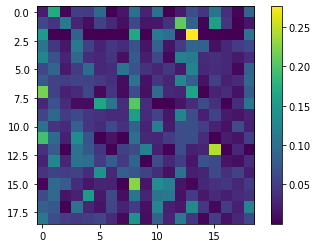

In [17]:
plt.imshow(candidates_probs_rnd)
plt.colorbar()

In [18]:
candidates_probs_rnd.std(axis=1)

y
BACHMANN_PRIMARY2012      0.046454
BIDEN_PRIMARY2008         0.054736
CAIN_PRIMARY2012          0.079400
CLINTON_PRIMARY2008       0.030988
EDWARDS_PRIMARY2008       0.037341
GINGRICH_PRIMARY2012      0.033312
GIULIANI_PRIMARY2008      0.032170
HUCKABEE_PRIMARY2008      0.055547
HUNTSMAN_PRIMARY2012      0.056208
MCCAIN_PRIMARY2008        0.036639
OBAMA_PRIMARY2008         0.029291
PAUL_PRIMARY2012          0.050096
PAWLENTY_PRIMARY2012      0.058716
PERRY_PRIMARY2012         0.035058
RICHARDSON_PRIMARY2008    0.031104
ROMNEY_PRIMARY2008        0.056783
ROMNEY_PRIMARY2012        0.041230
SANTORUM_PRIMARY2012      0.042457
THOMPSON_PRIMARY2008      0.037586
dtype: float64

0.04447988295181209


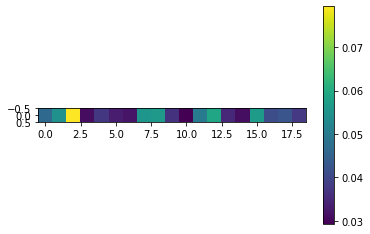

In [27]:
print(candidates_probs_rnd.std(axis=1).values.mean())
plt.imshow(np.expand_dims(candidates_probs_rnd.std(axis=1).values, axis=0))
plt.colorbar()

<AxesSubplot:xlabel='0'>

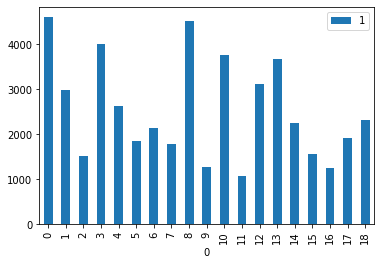

In [19]:
df = pd.DataFrame(pipe_19_glove_rnd.predict(np.array(all_data)))
df[1] = 1
df.groupby(0).sum().plot.bar()

# Stats GMM labeled centroids seed

In [20]:
df = pd.DataFrame(probs_19_glove_labelinit)
df['y'] = labeled.labels
candidates_probs_labelinit = df.groupby('y').mean()
candidates_probs_labelinit

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
y,,,,,,,,,,,,,,,,,,,
BACHMANN_PRIMARY2012,0.136987,0.004066,0.019843,0.014585,0.074375,0.001480,0.029361,0.050147,0.001550,0.011952,0.031974,0.023225,0.161445,0.081047,0.027070,0.053818,0.000254,0.101135,0.175686
BIDEN_PRIMARY2008,0.129400,0.086215,0.032295,0.000227,0.048697,0.000528,0.194544,0.009353,0.073202,0.184320,0.022409,0.048924,0.091043,0.002292,0.018010,0.017545,0.015622,0.013525,0.011851
CAIN_PRIMARY2012,0.009715,0.000016,0.224409,0.017397,0.099272,0.000132,0.074873,0.066351,0.047950,0.118258,0.001398,0.171533,0.000025,0.000066,0.000001,0.002330,0.000001,0.153251,0.013025
CLINTON_PRIMARY2008,0.038970,0.019569,0.023285,0.064345,0.088936,0.052004,0.048531,0.080771,0.015296,0.065887,0.077381,0.112811,0.017818,0.067517,0.048055,0.021215,0.043831,0.064302,0.049475
EDWARDS_PRIMARY2008,0.040084,0.038751,0.019927,0.009995,0.094314,0.028175,0.102825,0.077040,0.017370,0.104020,0.074053,0.118765,0.059029,0.051165,0.021419,0.030122,0.016988,0.042902,0.053056
GINGRICH_PRIMARY2012,0.094643,0.003740,0.058771,0.000741,0.073837,0.130270,0.045259,0.073844,0.038840,0.046657,0.024574,0.052345,0.047496,0.075239,0.010560,0.044835,0.041165,0.068611,0.068571
GIULIANI_PRIMARY2008,0.074681,0.044460,0.040856,0.037710,0.052654,0.019777,0.112131,0.054970,0.017618,0.134318,0.039810,0.079063,0.052389,0.018157,0.004719,0.053289,0.021278,0.047447,0.094674
HUCKABEE_PRIMARY2008,0.054415,0.017875,0.052616,0.024573,0.043673,0.024890,0.106402,0.137894,0.016911,0.040615,0.067962,0.146065,0.031844,0.017614,0.004182,0.032471,0.019917,0.095068,0.065013
HUNTSMAN_PRIMARY2012,0.037906,0.039469,0.003062,0.000424,0.056572,0.000113,0.009717,0.039455,0.094971,0.185757,0.008243,0.019528,0.146085,0.107659,0.034795,0.035359,0.035734,0.104573,0.040578


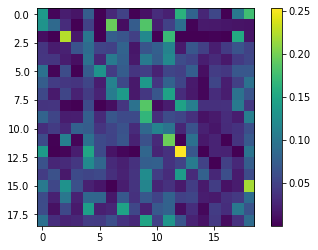

In [21]:
plt.imshow(candidates_probs_labelinit)
plt.colorbar()

In [22]:
candidates_probs_labelinit.std(axis=1)

y
BACHMANN_PRIMARY2012      0.055142
BIDEN_PRIMARY2008         0.059915
CAIN_PRIMARY2012          0.069665
CLINTON_PRIMARY2008       0.026744
EDWARDS_PRIMARY2008       0.033578
GINGRICH_PRIMARY2012      0.031526
GIULIANI_PRIMARY2008      0.033799
HUCKABEE_PRIMARY2008      0.041386
HUNTSMAN_PRIMARY2012      0.051881
MCCAIN_PRIMARY2008        0.037350
OBAMA_PRIMARY2008         0.027384
PAUL_PRIMARY2012          0.048024
PAWLENTY_PRIMARY2012      0.066855
PERRY_PRIMARY2012         0.030397
RICHARDSON_PRIMARY2008    0.032022
ROMNEY_PRIMARY2008        0.053788
ROMNEY_PRIMARY2012        0.026659
SANTORUM_PRIMARY2012      0.041232
THOMPSON_PRIMARY2008      0.037823
dtype: float64

0.04447988295181209


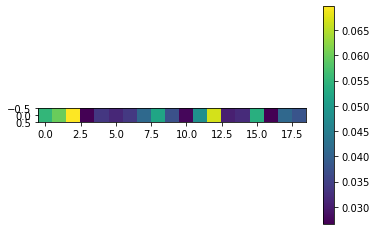

In [28]:
print(candidates_probs_rnd.std(axis=1).values.mean())
plt.imshow(np.expand_dims(candidates_probs_labelinit.std(axis=1).values, axis=0))
plt.colorbar()

<AxesSubplot:xlabel='0'>

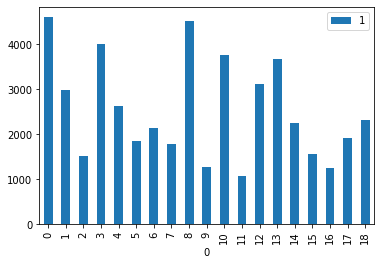

In [23]:
df = pd.DataFrame(pipe_19_glove_rnd.predict(np.array(all_data)))
df[1] = 1
df.groupby(0).sum().plot.bar()